# Time Evolution

Time evolutions in `quimb` are handled by the class {class}`~quimb.evo.Evolution`, which is initialized with a starting state and hamiltonian.

## Basic Usage

Set up the {class}`~quimb.evo.Evolution` object with a initial state and hamiltonian.

In [1]:
%config InlineBackend.figure_formats = ['svg']
import quimb as qu

p0 = qu.rand_ket(2**10)
h = qu.ham_heis(10, sparse=True)
evo = qu.Evolution(p0, h)

Update it in a single shot to a new time and get the state,

In [2]:
evo.update_to(1)
evo.pt

[[ 0.027396-0.00772j ]
 [ 0.00786 -0.019236j]
 [ 0.00165 +0.021386j]
 ...
 [-0.04785 -0.028168j]
 [ 0.006677+0.038223j]
 [ 0.011585-0.006924j]]

Lazily generate the state at multiple times:

In [3]:
for pt in evo.at_times([2, 3, 4]):
    print(qu.expec(pt, p0))

0.0003167209578964015
0.0033296109901839177
0.0012326190125073922


## Methods of Updating

There are three methods of updating the state:

> - `Evolution(..., method='integrate')`: use definite integration.
>   Get system at each time step, only need action of Hamiltonian on
>   state. Generally efficient. For pure and mixed states. The
>   additional option `int_small_step={False, True}` determines
>   whether a low or high order adaptive stepping scheme is used,
>   giving naturally smaller or larger times steps. See
>   {class}`scipy.integrate.ode` for details, `False` corresponds
>   to `"dop853"`, `True` to `"dopri5"`.
> - `Evolution(..., method='solve')`. Diagonalize the hamiltonian,
>   which once done, allows quickly updating to arbitrary times.
>   Supports pure and mixed states, recomended for small systems.
> - `Evolution(..., method='expm')`: compute the evolved state
>   using the action of the matrix exponential in a 'single shot'
>   style. Only needs action of Hamiltonian, for very large systems
>   can use distributed MPI. Only for pure states.

## Computing on the fly

Sometimes, if integrating, it is best to just query the state at time-steps chosen dynamically by the adaptive scheme. This is achieved using the `compute` keyword supplied to `Evolution`. It can also just be a convenient way to set up calculations as well:

In [4]:
p0 = qu.rand_product_state(10)
h = qu.ham_heis(10, sparse=True)

dims = [2] * 10
sysa, sysb = (0, 1), (2, 3)

def calc_t_and_logneg(t, pt):
    ln = qu.logneg_subsys(pt, dims, sysa, sysb)
    return t, ln

evo = qu.Evolution(p0, h, compute=calc_t_and_logneg, progbar=True)
evo.update_to(1)

ts, lns = zip(*evo.results)

100%|##########| 100/100 [00:00<00:00, 20516.06%/s]


In [5]:
ts

(0.0,
 0.2494153162899183,
 0.4809058736983094,
 0.7202389885285744,
 0.9908548077660357,
 1.0)

In [6]:
lns

(0.0,
 0.07922473340252047,
 0.19984430125848626,
 0.3726546674413778,
 0.5937245957372282,
 0.6011504266800122)

If a dict of callables is supplied to `compute`, (each should take two arguments, the time, and the state, as above), `Evolution.results` will itself be a dictionary containing the results of each function at each time step, under the respective key. This can be more convenient:

In [7]:
def calc_t(t, _):
    return t

def calc_logneg(_, pt):
    return qu.logneg_subsys(pt, [2]*10, 0, 1)

evo = qu.Evolution(p0, h, compute={'t': calc_t, 'ln': calc_logneg}, progbar=True)
evo.update_to(1)

100%|##########| 100/100 [00:00<00:00, 22323.19%/s]


In [8]:
evo.results

{'t': [0.0,
  0.2494153162899183,
  0.4809058736983094,
  0.7202389885285744,
  0.9908548077660357,
  1.0],
 'ln': [0.0,
  0.2670014309042237,
  0.4550737777089945,
  0.5894993607543968,
  0.6676819999827515,
  0.66894221219201]}

(time-dependent-evolution)=

## Time-Dependent Evolutions

If you are using `method='integrate'` you can supply a callable to `ham` to evolve the state with a time dependent Hamiltonian. It should take a single argument `t` and return the Hamiltonian at the time. It probably makes sense to use a custom class here to avoid reconstructing as much of the Hamiltonian as possible at each step.

Here we'll evolve the Neel state:

$$
| \psi(0) \rangle  = | \uparrow \downarrow \uparrow \downarrow \uparrow \ldots \rangle
$$

with the Hamiltonian:

$$
H(t) = \sum_{i = 0}^{L - 1} S^Z_{i} S^Z_{i + 1} + \cos(t) \sum_{i}^{L} S^X_i
$$

In [9]:
class MyTimeDepIsingHam:

    def __init__(self, L):
        self.h_interaction = qu.ham_ising(L, sparse=True, jz=1.0, bx=0.0, cyclic=False)
        self.h_field = qu.ham_ising(L, sparse=True, jz=0.0, bx=1.0, cyclic=False)

    def __call__(self, t):
        return self.h_interaction + qu.cos(t) * self.h_field

In [10]:
L = 16

# our initial state
psi0 = qu.neel_state(L)

# instantiate the ham object, it's __call__ method will be used by Evolution
fn_ham_t = MyTimeDepIsingHam(L)

We still want to compute some properties during the evolution:

In [11]:
compute = {
    'time': lambda t, p: t,
    'entropy': lambda t, p: qu.entropy_subsys(p, dims=[2] * L, sysa=range(L // 2))
}

Now we set up the evolution object again:

In [12]:
evo = qu.Evolution(psi0, fn_ham_t, progbar=True, compute=compute)

In [13]:
evo.update_to(10)

100%|##########| 100/100 [00:13<00:00,  7.64%/s]


We can plot the half chain entropy that we computed on the fly:

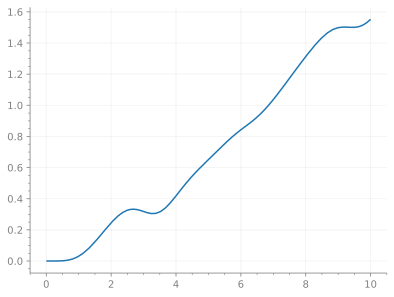

In [14]:
qu.plot(evo.results['time'], evo.results['entropy'])

Or we can use the final state:

In [15]:
qu.fidelity(psi0, evo.pt)

np.float64(0.003302180752068547)